In [1]:
!pip install pandas numpy scipy statsmodels matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(42)
hours_studied = np.random.normal(5, 2, 100)
sleep_hours = np.random.normal(7, 1.5, 100)

In [4]:
exam_score = 10 * hours_studied + 2 * sleep_hours + np.random.normal(0, 5, 100)

df = pd.DataFrame({
    'hours_studied': hours_studied,
    'sleep_hours': sleep_hours,
    'exam_score': exam_score
})


In [5]:
missing = df.isnull().sum()

In [6]:
from scipy.stats import zscore
z_scores = np.abs(zscore(df))
outliers = (z_scores > 3).any(axis=1)
outlier_report = df[outliers]

In [7]:
cleaned_df = df[~outliers]

In [8]:
cleaned_df.to_csv("cleaned_data.csv", index=False)
print("Missing values:\n", missing)
print("\nOutliers:\n", outlier_report)

Missing values:
 hours_studied    0
sleep_hours      0
exam_score       0
dtype: int64

Outliers:
 Empty DataFrame
Columns: [hours_studied, sleep_hours, exam_score]
Index: []


In [9]:
correlation_matrix = cleaned_df[['hours_studied', 'sleep_hours']].corr()
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
                hours_studied  sleep_hours
hours_studied       1.000000    -0.136422
sleep_hours        -0.136422     1.000000


In [10]:
features = cleaned_df[['hours_studied', 'sleep_hours']]
standardized_features = (features - features.mean()) / features.std()

In [11]:
X = np.c_[np.ones(len(standardized_features)), standardized_features]
y = cleaned_df['exam_score'].values

In [12]:
def mse(beta):
    predictions = X @ beta
    return np.mean((y - predictions) ** 2)

In [13]:
initial_beta = np.zeros(X.shape[1])

In [14]:
result = minimize(mse, initial_beta)
beta_opt = result.x

In [15]:
y_pred = X @ beta_opt
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print("Optimized coefficients:", beta_opt)
print("R-squared:", r_squared)

Optimized coefficients: [62.31446435 19.19000478  2.8024671 ]
R-squared: 0.9273442171367535


In [16]:
X_sm = sm.add_constant(cleaned_df[['hours_studied', 'sleep_hours']])
model = sm.OLS(cleaned_df['exam_score'], X_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     619.0
Date:                Thu, 08 May 2025   Prob (F-statistic):           5.91e-56
Time:                        16:40:36   Log-Likelihood:                -308.57
No. Observations:                 100   AIC:                             623.1
Df Residuals:                      97   BIC:                             630.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.0964      3.256     -0.644

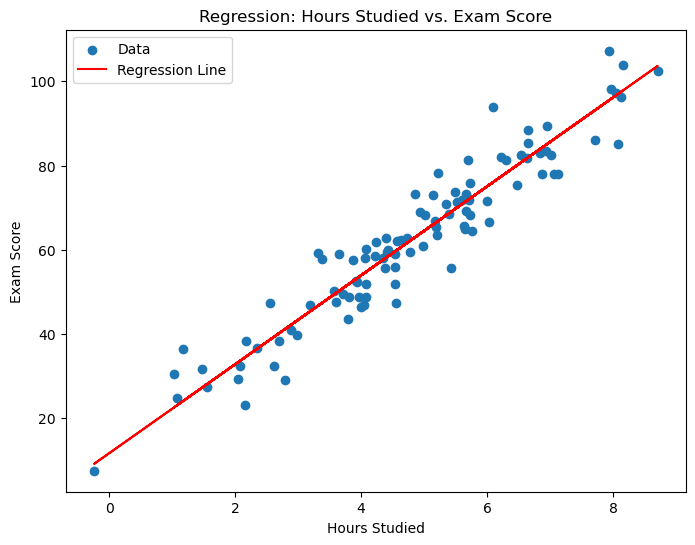

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(cleaned_df['hours_studied'], cleaned_df['exam_score'], label='Data')
slope = model.params['hours_studied']
intercept = model.params['const'] + model.params['sleep_hours'] * cleaned_df['sleep_hours'].mean()
plt.plot(cleaned_df['hours_studied'], intercept + slope * cleaned_df['hours_studied'], color='red', label='Regression Line')
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Regression: Hours Studied vs. Exam Score")
plt.legend()
plt.savefig("regression_plot.png")
plt.show()

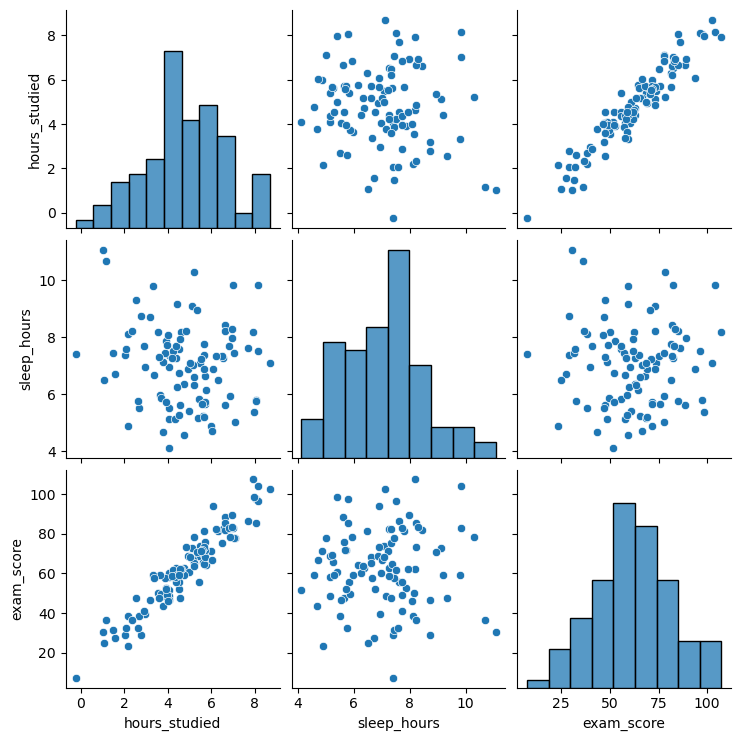

In [18]:
sns.pairplot(cleaned_df)
plt.savefig("pairplot.png")
plt.show()

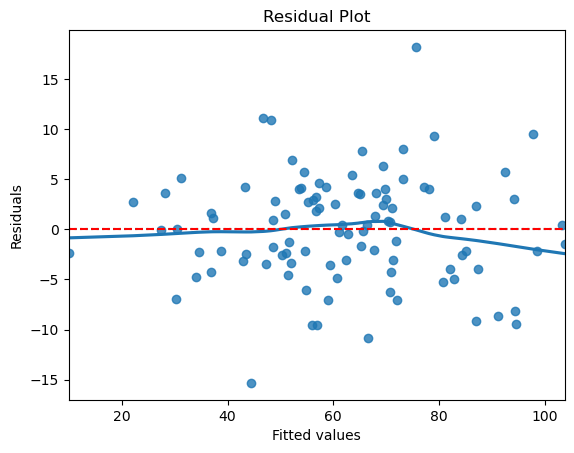

In [19]:
residuals = model.resid
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='red', linestyle='--')
plt.savefig("residual_plot.png")
plt.show()